<a href="https://colab.research.google.com/github/namigabbasov/ai-literacy-bibliometric-analysis/blob/main/scripts/RQ3_country_productivity_and_collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RQ3 — Countries (Geographic Productivity & Collaboration)**

## Setup: Install and Import Required Libraries

In [ ]:
resol=1000

In [ ]:
!pip install -q python-louvain networkx matplotlib seaborn pandas numpy pycountry geodatasets geopandas
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import re
import community as community_louvain  # python-louvain
import pycountry
from itertools import combinations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import community.community_louvain as community_louvain

import re, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
import community.community_louvain as community_louvain
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
sns.set(style="whitegrid")


##

## Load AI Literacy Dataset from GitHub

In [ ]:
url = "https://raw.githubusercontent.com/namigabbasov/ai-literacy-bibliometric-analysis/refs/heads/main/data/ai_literacy.csv"
df = pd.read_csv(url, low_memory=False)

## Top 10 Countries

In [ ]:
dfC = df.copy()

def extract_countries(affil):
    if pd.isna(affil):
        return []
    parts = [p.strip() for p in str(affil).split(';') if p.strip()]
    countries = []
    for p in parts:
        # Extract last comma-separated token
        match = p.split(',')[-1].strip()
        if match and match.lower() not in ["nan", "none", "null"]:
            countries.append(match)
    return list(set(countries))  # unique

dfC["country_list"] = dfC["Affiliations"].apply(extract_countries)

# explode for country counts
country_exploded = dfC.explode("country_list")
country_exploded = country_exploded[country_exploded["country_list"].notna()]


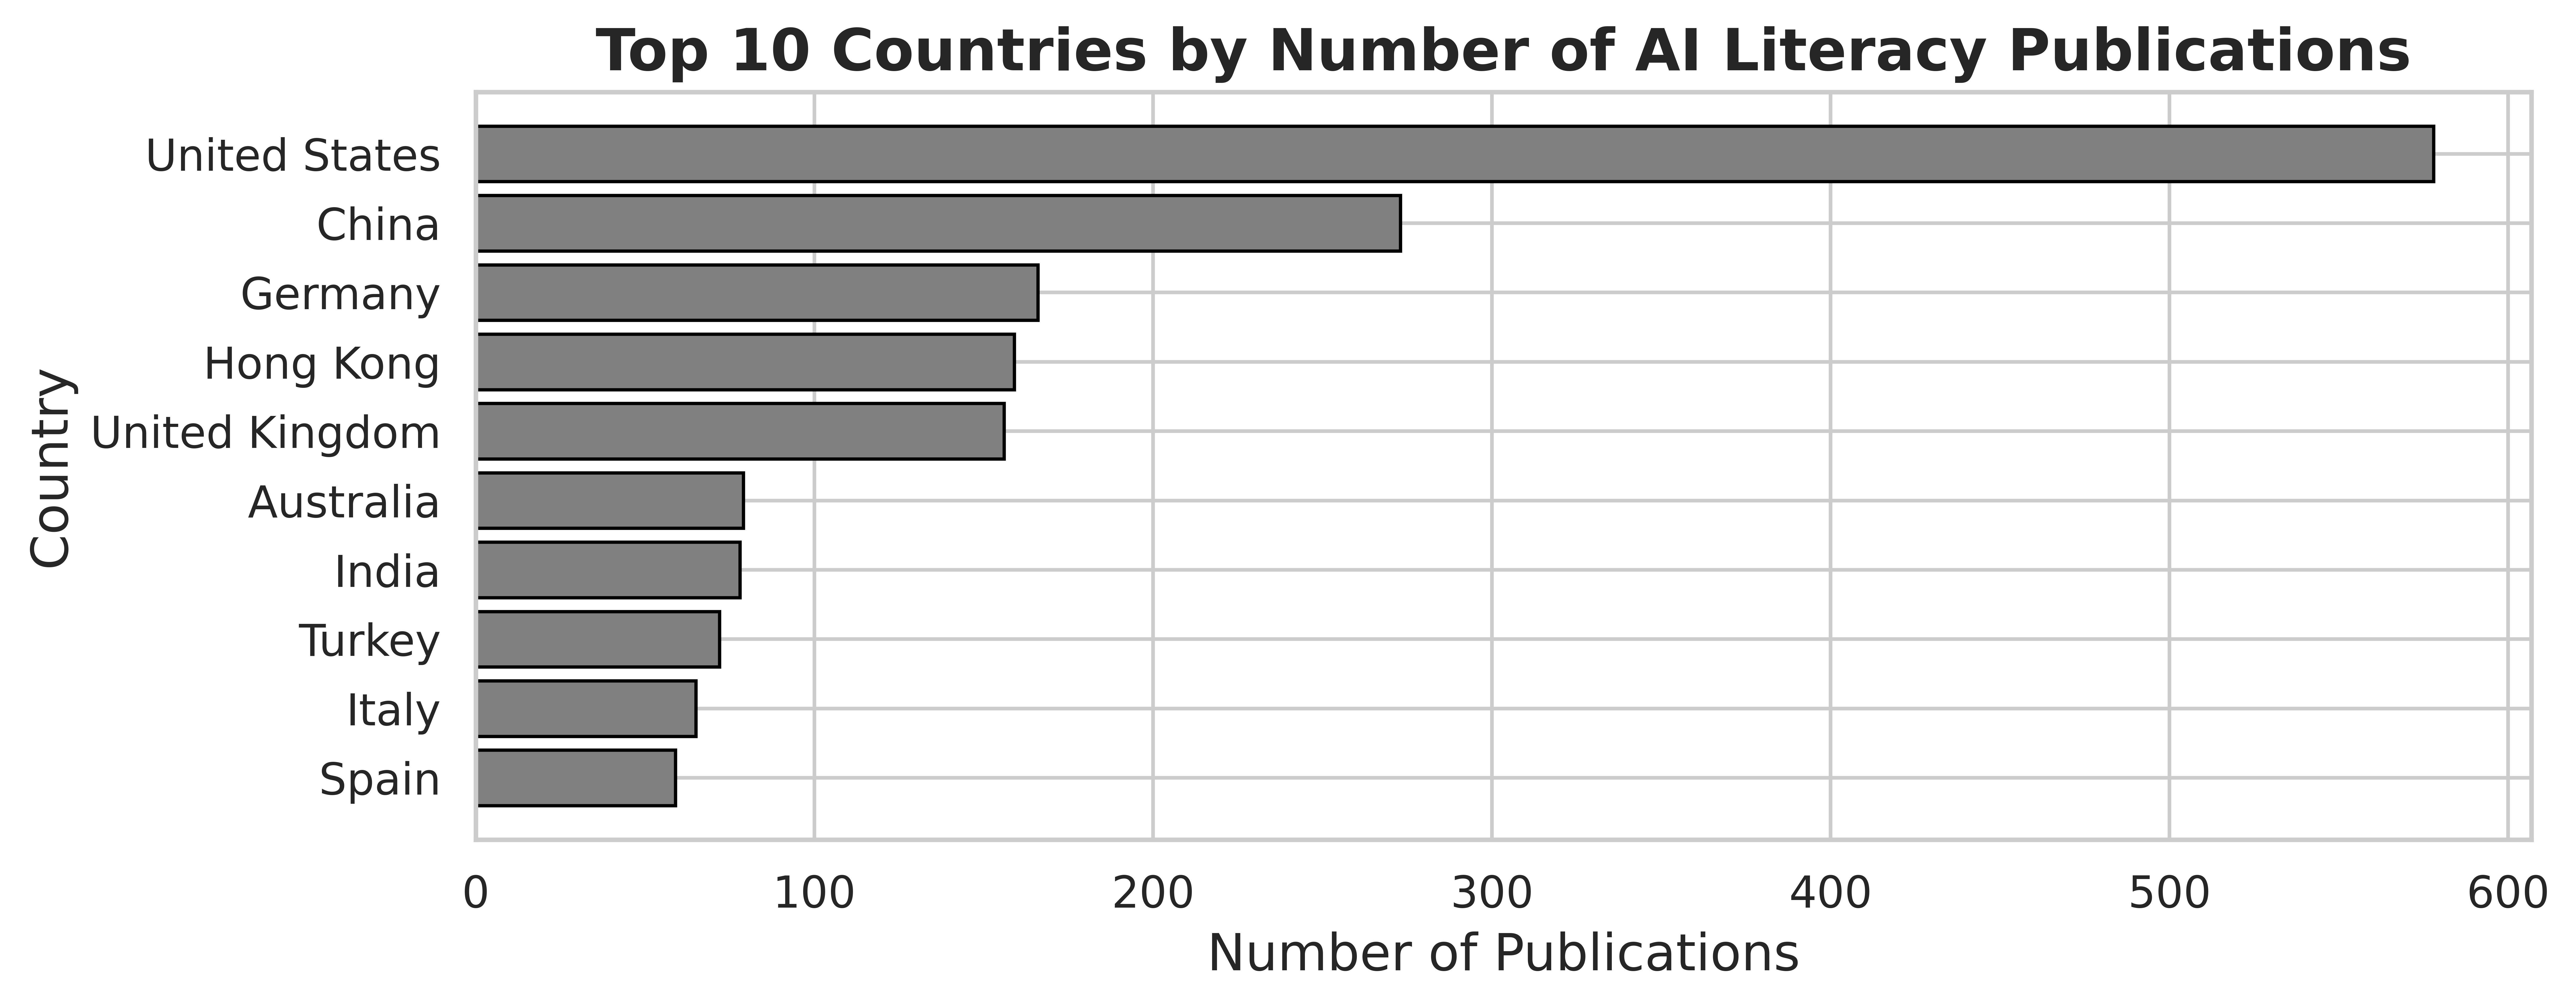

In [ ]:
# TOP 10 COUNTRIES BY PUBLICATION COUNT
top_countries = (
    country_exploded["country_list"]
    .value_counts()
    .head(10)
    .rename_axis("Country")
    .reset_index(name="Publications")
)

plt.figure(figsize=(10,4), dpi=resol)

plt.barh(
    top_countries["Country"],
    top_countries["Publications"],
    color="gray",
    edgecolor="black",
    linewidth=0.9
)

plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Number of AI Literacy Publications", fontsize=16, weight="bold")
plt.xlabel("Number of Publications", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.28)
plt.tight_layout()
plt.show()


## Country Network Colloborations

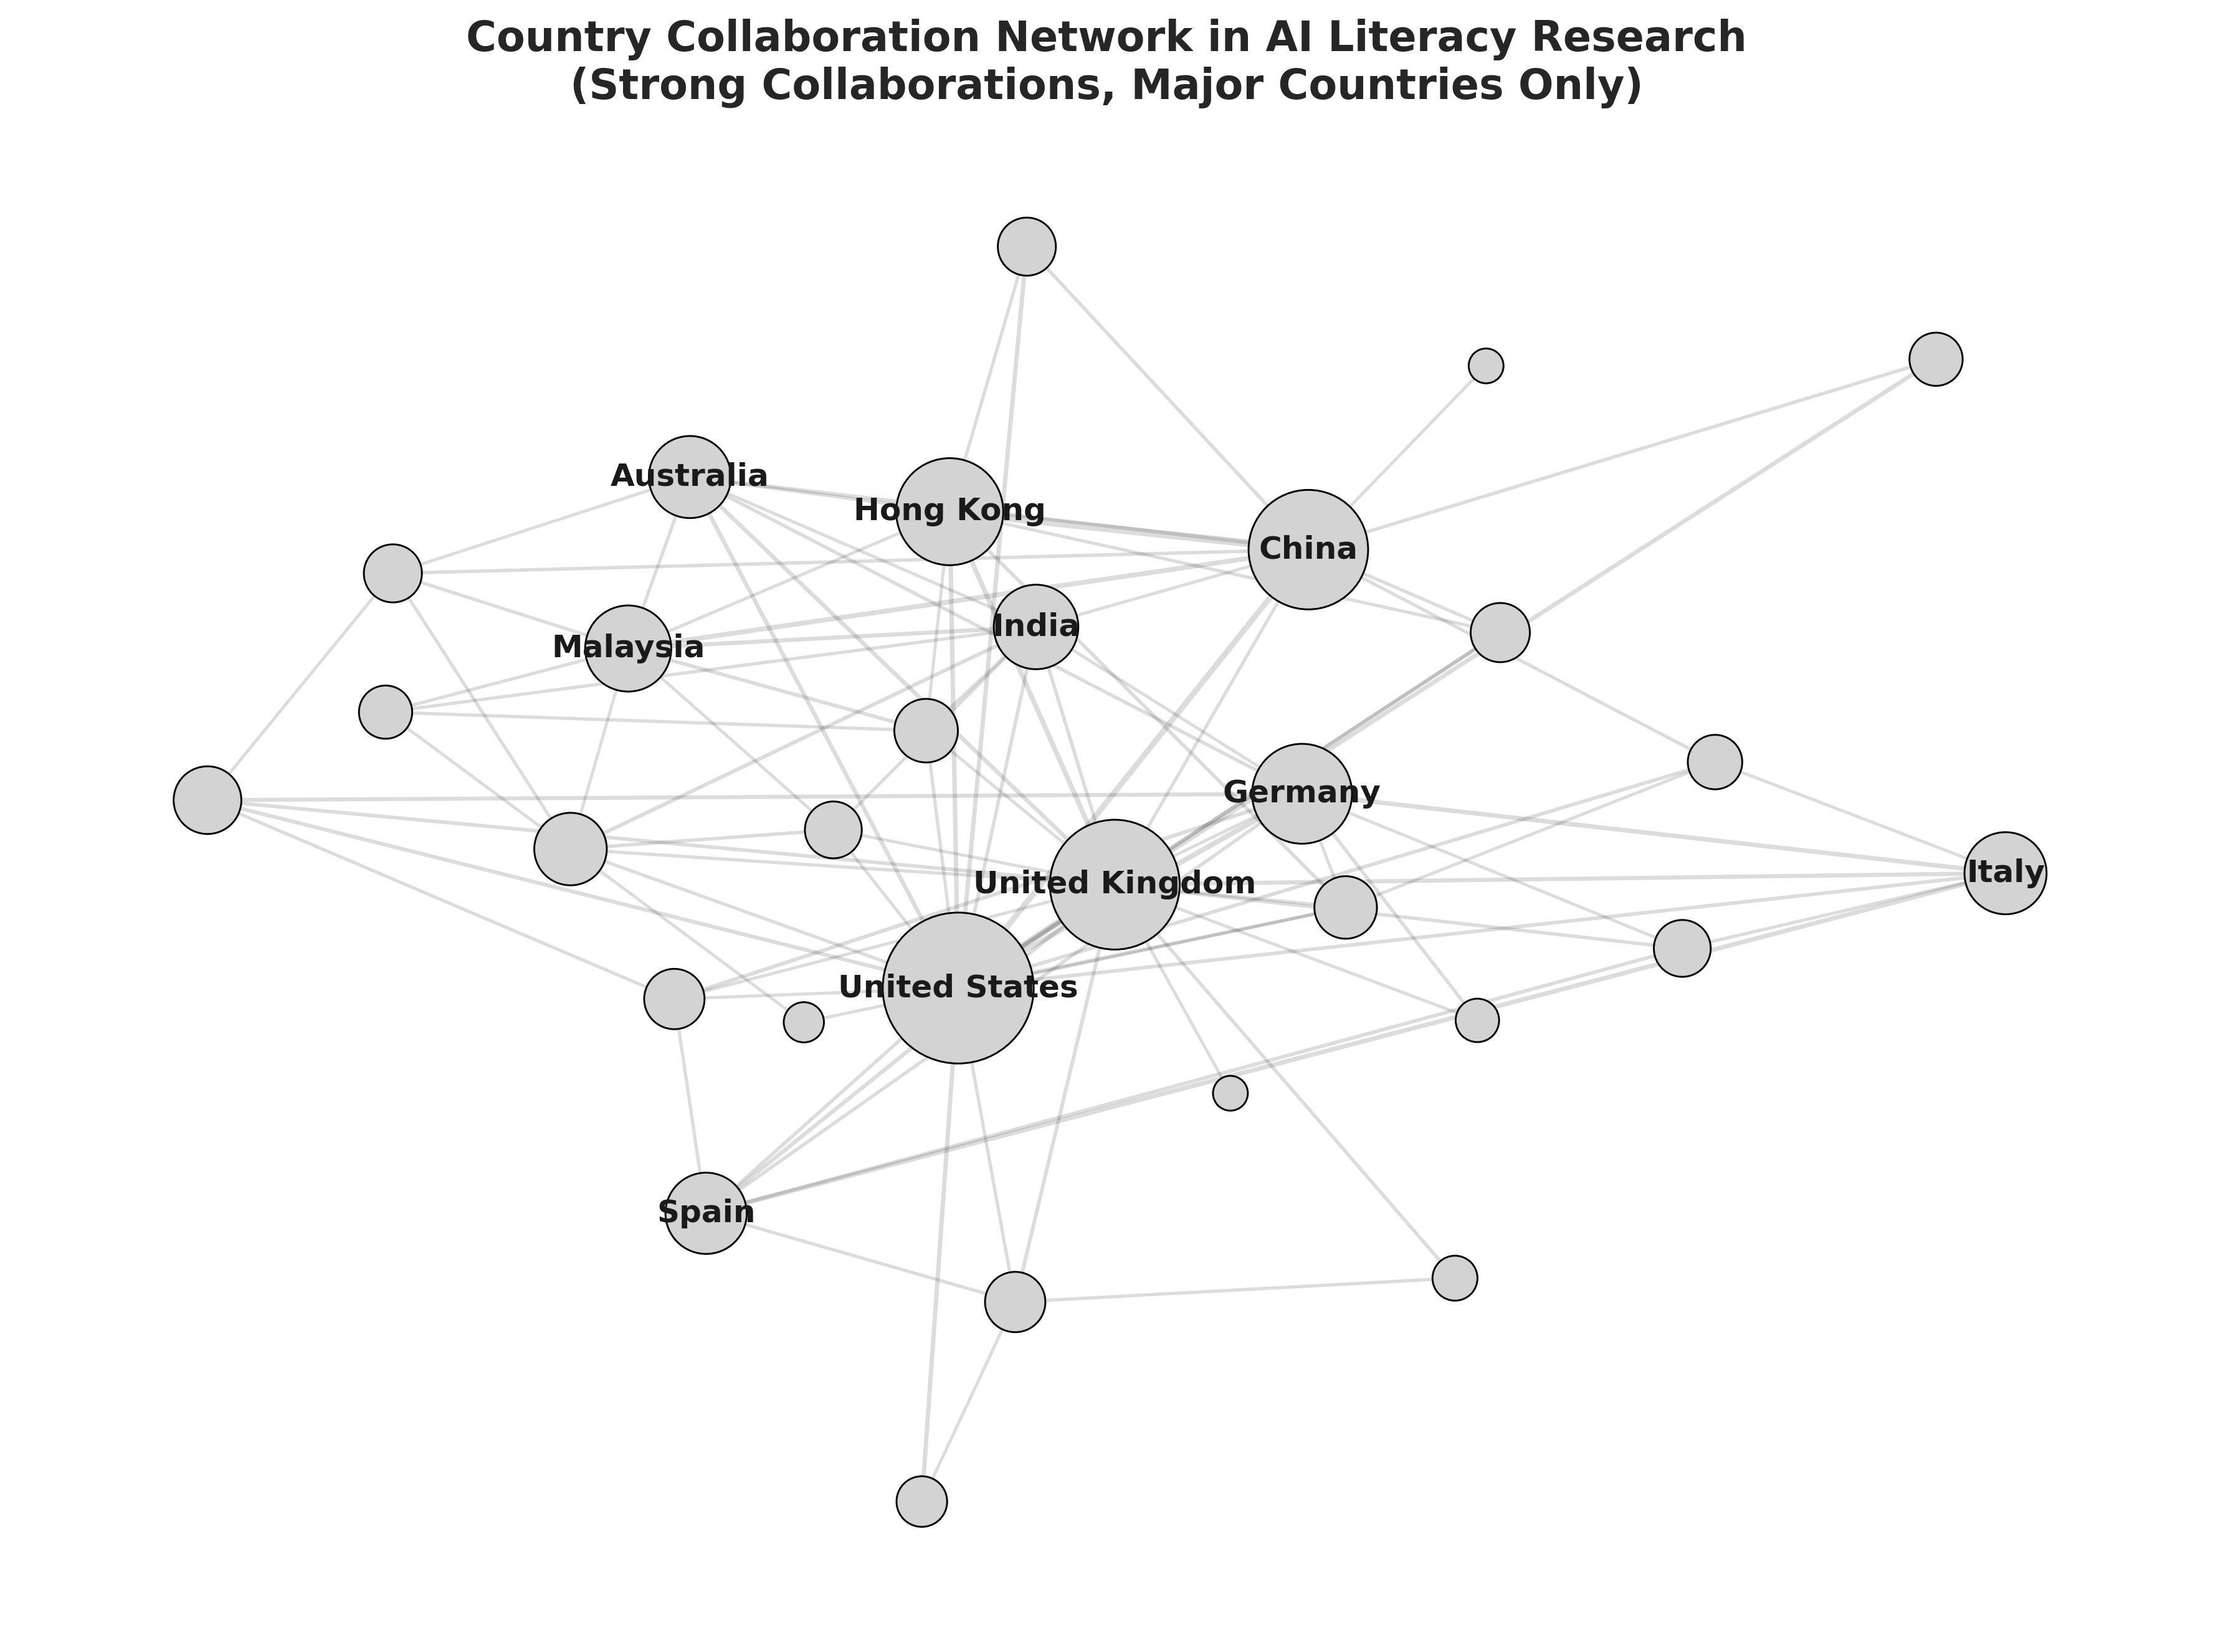

Top collaborative countries: [('United States', 163), ('United Kingdom', 119), ('China', 100), ('Hong Kong', 79), ('Germany', 68), ('Malaysia', 49), ('India', 47), ('Australia', 44), ('Italy', 44), ('Spain', 43)]


In [ ]:
#Strong ties only, major countries only

dfC = df.copy()

def extract_countries(affil):
    if pd.isna(affil): return []
    parts = [p.strip() for p in str(affil).split(";") if p.strip()]
    countries = []
    for p in parts:
        c = p.split(",")[-1].strip()
        if c.lower() not in ["nan","none","null"]:
            countries.append(c)
    return list(set(countries))

dfC["country_list"] = dfC["Affiliations"].apply(extract_countries)

# explode for counts
country_exploded = dfC.explode("country_list")
country_counts = country_exploded["country_list"].value_counts()


MAJOR_THRESHOLD = 20
major_countries = set(country_counts[country_counts >= MAJOR_THRESHOLD].index)

dfC_major = dfC[dfC["country_list"].apply(
    lambda lst: any(c in major_countries for c in lst)
)]


G_country = nx.Graph()
edge_weights = {}

for _, row in dfC_major.iterrows():
    clist = [c for c in row["country_list"] if c in major_countries]
    if len(clist) < 2:
        continue
    for a, b in itertools.combinations(set(clist), 2):
        edge_weights[(a,b)] = edge_weights.get((a,b), 0) + 1

# keep strong edges ONLY
STRONG_EDGE = 3
G_country = nx.Graph()
for (a,b), w in edge_weights.items():
    if w >= STRONG_EDGE:
        G_country.add_edge(a, b, weight=w)

# prune isolated nodes
isol = [n for n,d in G_country.degree() if d == 0]
G_country.remove_nodes_from(isol)


strength = dict(G_country.degree(weight="weight"))
node_sizes = [120 + 20*strength[n] for n in G_country.nodes()]

pos = nx.kamada_kawai_layout(G_country)

# edge widths
weights = [G_country[u][v]["weight"] for u,v in G_country.edges()]
max_w = max(weights) if weights else 1
edge_widths = [1 + 2*(w/max_w) for w in weights]

# DRAW NETWORK
plt.figure(figsize=(12,9), dpi=300)

nx.draw_networkx_edges(G_country, pos, width=edge_widths, alpha=0.15)

nx.draw_networkx_nodes(
    G_country, pos,
    node_size=node_sizes,
    node_color="lightgray",
    edgecolors="black",
    linewidths=0.7
)

# Label only top 8–10 countries
top_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)[:10]
labelset = set([a for a, _ in top_strength])
labels = {n: (n if n in labelset else "") for n in G_country.nodes()}

nx.draw_networkx_labels(G_country, pos, labels=labels,
                        font_size=12, font_weight="bold")

plt.title("Country Collaboration Network in AI Literacy Research\n(Strong Collaborations, Major Countries Only)",
          fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

print("Top collaborative countries:", top_strength)


## Publication Map

In [ ]:
dfC = df.copy()

# Function to extract country names
def extract_countries(affil):
    """Extracts last comma-separated token from each affiliation block."""
    if pd.isna(affil):
        return []
    parts = [p.strip() for p in str(affil).split(";") if p.strip()]
    countries = []
    for p in parts:
        # take last segment after comma
        country = p.split(",")[-1].strip()
        if country and country.lower() not in ["nan", "null", "none"]:
            countries.append(country)
    return list(set(countries))   # remove duplicates inside each cell

# Apply extraction
dfC["country_list"] = dfC["Affiliations"].apply(extract_countries)

# Build a master list of countries
all_countries = (
    dfC["country_list"]
    .explode()
    .dropna()
    .unique()
)

all_countries = sorted(all_countries)

for c in all_countries:
    print(c)

print("\nTotal unique extracted country names:", len(all_countries))


Afghanistan
Albania
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belgium
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Cambodia
Cameroon
Canada
Cape Verde
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Czech Republic
Denmark
Ecuador
Egypt
Estonia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Hong Kong
Hungary
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kuwait
Laos
Latvia
Lebanon
Lesotho
Lithuania
Luxembourg
Macao
Malawi
Malaysia
Maldives
Malta
Mauritius
Mexico
Moldova
Morocco
Mozambique
Nepal
Netherlands
New Zealand
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
ReadyAI
Romania
Russian Federation
Rwanda
Saint Kitts and Nevis
Saudi Arabia
Serbia
Singapore
Slovakia
Slovenia
South Africa
South Korea
Spain
Sri Lanka
Sudan
Sweden
Switzerland
Taiwan
Tanzania
Thailand
Trinidad and Tobago
Tunisia
Turkey
Uganda
Ukraine
United Arab Emirates


In [ ]:
###  map of publications

### Extract countries fresh
def extract_countries(affil):
    if pd.isna(affil):
        return []
    parts = [p.strip() for p in str(affil).split(";") if p.strip()]
    out = []
    for p in parts:
        c = p.split(",")[-1].strip()
        if c and c.lower() not in ["nan","none","null","","animacy"]:
            out.append(c)
    return list(set(out))

dfC = df.copy()
dfC["country_list"] = dfC["Affiliations"].apply(extract_countries)

country_exploded = dfC.explode("country_list")
country_exploded = country_exploded[country_exploded["country_list"].notna()]

country_counts = (
    country_exploded["country_list"]
    .value_counts()
    .rename_axis("Country")
    .reset_index(name="Publications")
)

# Mapping dictionary
country_name_map = {
    "Afghanistan":"Afghanistan","Albania":"Albania","Algeria":"Algeria","Argentina":"Argentina",
    "Armenia":"Armenia","Australia":"Australia","Austria":"Austria","Azerbaijan":"Azerbaijan",
    "Bahrain":"Bahrain","Bangladesh":"Bangladesh","Belgium":"Belgium",
    "Bosnia and Herzegovina":"Bosnia and Herzegovina","Botswana":"Botswana","Brazil":"Brazil",
    "Brunei Darussalam":"Brunei","Bulgaria":"Bulgaria","Cambodia":"Cambodia","Cameroon":"Cameroon",
    "Canada":"Canada","Cape Verde":"Cabo Verde","Chile":"Chile","China":"China","Colombia":"Colombia",
    "Costa Rica":"Costa Rica","Croatia":"Croatia","Cyprus":"Cyprus","Czech Republic":"Czechia",
    "Denmark":"Denmark","Ecuador":"Ecuador","Egypt":"Egypt","Estonia":"Estonia","Finland":"Finland",
    "France":"France","Georgia":"Georgia","Germany":"Germany","Ghana":"Ghana","Greece":"Greece",
    "Guatemala":"Guatemala","Hong Kong":"Hong Kong","Hungary":"Hungary","India":"India",
    "Indonesia":"Indonesia","Iran":"Iran","Iraq":"Iraq","Ireland":"Ireland","Israel":"Israel",
    "Italy":"Italy","Jamaica":"Jamaica","Japan":"Japan","Jordan":"Jordan","Kazakhstan":"Kazakhstan",
    "Kenya":"Kenya","Kuwait":"Kuwait","Laos":"Lao PDR","Latvia":"Latvia","Lebanon":"Lebanon",
    "Lesotho":"Lesotho","Lithuania":"Lithuania","Luxembourg":"Luxembourg","Macao":"Macau",
    "Malawi":"Malawi","Malaysia":"Malaysia","Maldives":"Maldives","Malta":"Malta",
    "Mauritius":"Mauritius","Mexico":"Mexico","Moldova":"Moldova","Morocco":"Morocco",
    "Mozambique":"Mozambique","Nepal":"Nepal","Netherlands":"Netherlands","New Zealand":"New Zealand",
    "Nigeria":"Nigeria","North Macedonia":"North Macedonia","Norway":"Norway","Oman":"Oman",
    "Pakistan":"Pakistan","Palestine":"Palestine","Peru":"Peru","Philippines":"Philippines",
    "Poland":"Poland","Portugal":"Portugal","Puerto Rico":None,"Qatar":"Qatar",
    "Romania":"Romania","Russian Federation":"Russia","Rwanda":"Rwanda",
    "Saint Kitts and Nevis":"Saint Kitts and Nevis","Saudi Arabia":"Saudi Arabia","Serbia":"Serbia",
    "Singapore":"Singapore","Slovakia":"Slovakia","Slovenia":"Slovenia","South Africa":"South Africa",
    "South Korea":"South Korea","Spain":"Spain","Sri Lanka":"Sri Lanka","Sudan":"Sudan",
    "Sweden":"Sweden","Switzerland":"Switzerland","Taiwan":None,"Tanzania":"Tanzania",
    "Thailand":"Thailand","Trinidad and Tobago":"Trinidad and Tobago","Tunisia":"Tunisia",
    "Turkey":"Türkiye","Uganda":"Uganda","Ukraine":"Ukraine",
    "United Arab Emirates":"United Arab Emirates",
    "United Kingdom":"United Kingdom",
    "United States":"United States of America",
    "Uruguay":"Uruguay","Uzbekistan":"Uzbekistan","Viet Nam":"Vietnam","Zambia":"Zambia",
    "Zimbabwe":"Zimbabwe"
}

# Apply mapping CLEANLY
country_counts["Country_NE"] = country_counts["Country"].map(country_name_map)
country_counts = country_counts[country_counts["Country_NE"].notna()]


# Load Natural Earth world map
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)

# Merge and PLOT

merged = world.merge(
    country_counts,
    left_on="NAME",
    right_on="Country_NE",
    how="left"
)

merged["Publications"] = merged["Publications"].fillna(0)

fig, ax = plt.subplots(figsize=(12,8), dpi=1000)

merged.plot(
    column="Publications",
    cmap="Blues",
    linewidth=0.4,
    edgecolor="black",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Number of AI Literacy Publications",
        "orientation": "vertical",
        "shrink": 0.5
    }
)

ax.set_title("Global Distribution of AI Literacy Publications",
             fontsize=26, fontweight="bold", pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()


## Descriptive Countries in Table

In [ ]:
### full countries
def extract_countries(affil):
    if pd.isna(affil):
        return []
    parts = [p.strip() for p in str(affil).split(";") if p.strip()]
    out = []
    for p in parts:
        c = p.split(",")[-1].strip()
        if c.lower() not in ["nan","none","null",""]:
            out.append(c)
    return list(set(out))

df_country = df.copy()
df_country["country_list"] = df_country["Affiliations"].apply(extract_countries)

# Ensure 'Cited by' numeric
df_country["Cited by"] = pd.to_numeric(df_country["Cited by"], errors="coerce").fillna(0)


# Build country → paper relationships

country_exploded = df_country.explode("country_list")
country_exploded = country_exploded[country_exploded["country_list"].notna()]

# Rename
country_exploded = country_exploded.rename(columns={"country_list": "Country"})


# Compute Article Counts, Mean Citations, Total Citations
country_summary = (
    country_exploded.groupby("Country")
    .agg(
        num_articles=("EID", "count"),
        mean_citations=("Cited by", "mean"),
        total_citations=("Cited by", "sum")
    )
)

# Compute SCP (Single Country Papers) and MCP (Multi Country Papers)

df_country["is_multiple_country"] = df_country["country_list"].apply(
    lambda x: len(x) > 1
)

# Count SCP and MCP per country
scp = []
mcp = []

for country in country_summary.index:
    # Papers where this country appears
    papers = df_country[df_country["country_list"].apply(lambda lst: country in lst if isinstance(lst, list) else False)]

    scp.append(sum(papers["is_multiple_country"] == False))
    mcp.append(sum(papers["is_multiple_country"] == True))

country_summary["SCP"] = scp
country_summary["MCP"] = mcp

# Sort by # of Articles (descending)
country_summary = country_summary.sort_values("num_articles", ascending=False)

country_summary["mean_citations"] = country_summary["mean_citations"].round(2)

country_summary


num_articles  mean_citations  total_citations  SCP  MCP
Country                                                                     
United States                 577           14.06           8126.0  444  134
China                         273           10.81           2952.0  177   96
Germany                       166           15.48           2569.0  100   66
Hong Kong                     159           51.10           8125.0   94   65
United Kingdom                156            9.42           1470.0   61   95
...                           ...             ...              ...  ...  ...
Rwanda                          1           47.00             47.0    0    1
Sudan                           1            0.00              0.0    1    0
Sri Lanka                       1            0.00              0.0    0    1
Trinidad and Tobago             1            0.00              0.0    1    0
animacy                         1            0.00              0.0    1    0

[118 rows x 5 columns]

In [ ]:
### subset countries with at least 20 articles
countries_20plus = country_summary[country_summary["num_articles"] >= 20]
countries_20plus
countries_20plus.to_excel("Countries_20plus_AI_Literacy.xlsx", index=True)